# <center>ISsoft ML Meetups (DEMO).

## <center>"Машинное обучение: погружение в Kaggle на борту Титаника" (часть вторая)
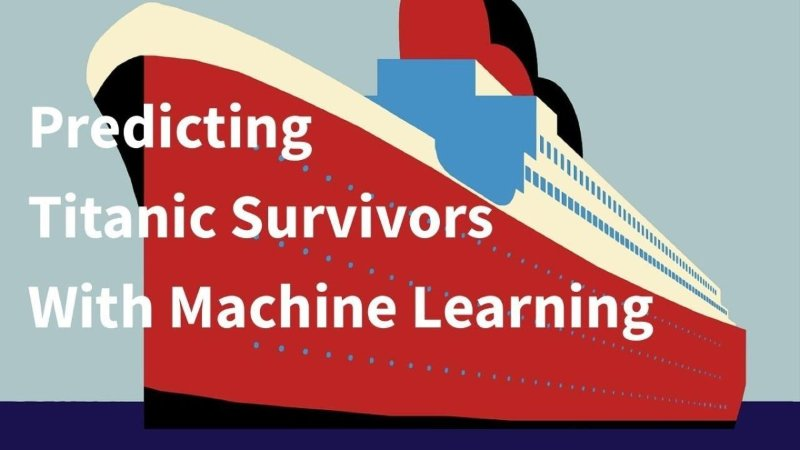

## Что было в прошлой части:



- Немного поговорили о машинном обучении, Kaggle и инструментах для решения Data Science задач


- Предобработали данные: заполнили пропуски, удалили ненужные колонки


- Сделали простую визуализацию, которая позволила лучше понять данные


- На основании визуализации данных сделали выводы и реализовали их в виде baseline-модели - решающего пня



- Получили Accuracy 59% - результат явно выше простого угадывания

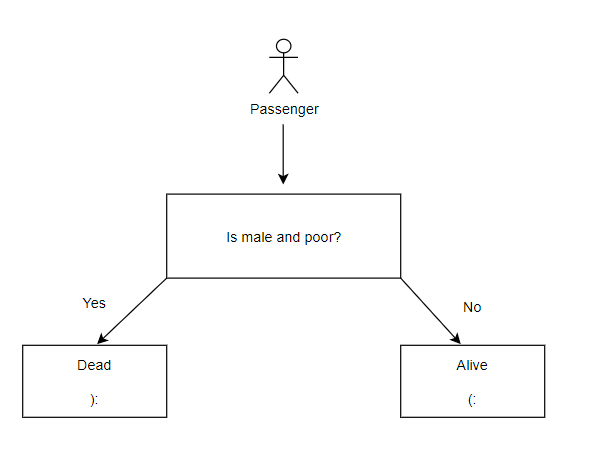

## Прежде, чем начать обучать алгоритмы....

...нужно ещё немного повозиться с данными

In [25]:
import pandas as pd

In [26]:
#Путь к данным

PATH_TO_TRAIN = 'train_imputed.csv'
PATH_TO_TEST = 'test_imputed.csv'

In [27]:
#Загрузка данных

train = pd.read_csv(PATH_TO_TRAIN, index_col='PassengerId') #обучающая выборка
test = pd.read_csv(PATH_TO_TEST, index_col='PassengerId')   #тестовая выборка (для неё будем предсказывать)

In [28]:
train

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
PassengerId                                                                   
1                   0       3    male  22.0      1      0   7.2500        S   
2                   1       1  female  38.0      1      0  71.2833        C   
3                   1       3  female  26.0      0      0   7.9250        S   
4                   1       1  female  35.0      1      0  53.1000        S   
5                   0       3    male  35.0      0      0   8.0500        S   
...               ...     ...     ...   ...    ...    ...      ...      ...   
887                 0       2    male  27.0      0      0  13.0000        S   
888                 1       1  female  19.0      0      0  30.0000        S   
889                 0       3  female  28.0      1      2  23.4500        S   
890                 1       1    male  26.0      0      0  30.0000        C   
891                 0       3    male  32.0      0      0   7.7500        Q   

             Family_size  
PassengerId               
1                      1  
2                      1  
3                      0  
4                      1  
5                      0  
...                  ...  
887                    0  
888                    0  
889                    3  
890                    0  
891                    0  

[891 rows x 9 columns]

In [29]:
#перепроверили, те ли это (заполненные ли) данные

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    object 
 8   Family_size  891 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 69.6+ KB


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Sex          418 non-null    object 
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   Embarked     418 non-null    object 
 7   Family_size  418 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 29.4+ KB


### Отделяем целевую переменную от обучающей выборки

In [31]:
#Отделим колонку с 'ответом' от тестовой выборки, чтобы не путать алгоритм

y_train = train['Survived']
train_sep = train.drop(columns=['Survived'])

### Кодирование категориальных признаков (one-hot-encoding)

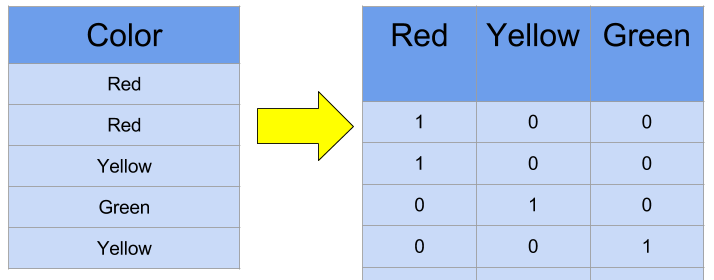

In [32]:
#One-hot-encoding категориальных переменных

def encode_categorical(df_train, df_test):
    
    test_start_ind = df_train.index[-1] #запомнили индекс, с которого начинаются тестовые данные
    
    concated_df = pd.concat([df_train, df_test], sort=False) #объединили обучающую выборку с тестовой, для корректности
                                                             #преобразования
        
    encoded_df = pd.get_dummies(concated_df, drop_first=True)#преобразовали
    
    
    df_train_encoded, df_test_encoded = encoded_df.iloc[:test_start_ind, :], encoded_df.iloc[test_start_ind:, :] #разъединили
    
    return df_train_encoded, df_test_encoded

In [33]:
X_train, X_test = encode_categorical(train_sep, test)

In [35]:
#смотрим на результат

X_test

Pclass   Age  SibSp  Parch      Fare  Family_size  Sex_male  \
PassengerId                                                                
892               3  34.5      0      0    7.8292            0         1   
893               3  47.0      1      0    7.0000            1         0   
894               2  62.0      0      0    9.6875            0         1   
895               3  27.0      0      0    8.6625            0         1   
896               3  22.0      1      1   12.2875            2         0   
...             ...   ...    ...    ...       ...          ...       ...   
1305              3  27.0      0      0    8.0500            0         1   
1306              1  39.0      0      0  108.9000            0         0   
1307              3  38.5      0      0    7.2500            0         1   
1308              3  27.0      0      0    8.0500            0         1   
1309              3  27.0      1      1   22.3583            2         1   

             Embarked_Q  Embarked_S  
PassengerId                          
892                   1           0  
893                   0           1  
894                   1           0  
895                   0           1  
896                   0           1  
...                 ...         ...  
1305                  0           1  
1306                  0           0  
1307                  0           1  
1308                  0           1  
1309                  0           0  

[418 rows x 9 columns]

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    int64  
 3   Parch        891 non-null    int64  
 4   Fare         891 non-null    float64
 5   Family_size  891 non-null    int64  
 6   Sex_male     891 non-null    uint8  
 7   Embarked_Q   891 non-null    uint8  
 8   Embarked_S   891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 51.3 KB


In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Age          418 non-null    float64
 2   SibSp        418 non-null    int64  
 3   Parch        418 non-null    int64  
 4   Fare         418 non-null    float64
 5   Family_size  418 non-null    int64  
 6   Sex_male     418 non-null    uint8  
 7   Embarked_Q   418 non-null    uint8  
 8   Embarked_S   418 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 24.1 KB


#### Теперь можно переходить к работе с алгоритмом! :)

## <center> Решающее дерево (Decision tree)

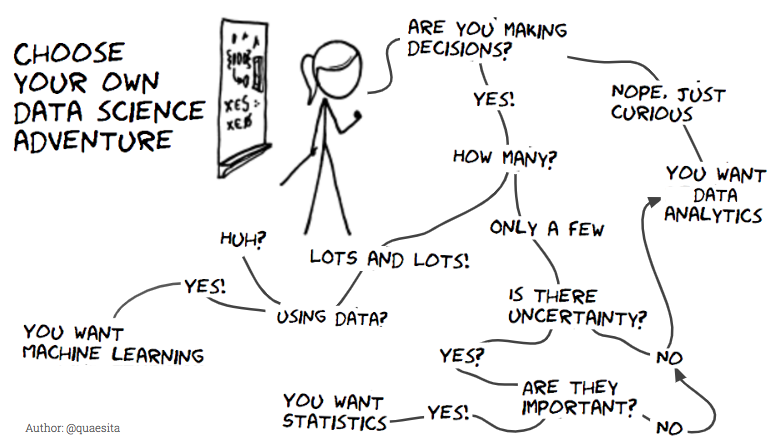

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
#в лоб
dt_clf = DecisionTreeClassifier()

In [43]:
%%time

dt_clf.fit(X_train, y_train)

Wall time: 4 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [45]:
pred_dt_simple = dt_clf.predict(X_test)

#### Визуализация решающего дерева

In [46]:
from sklearn.tree import export_graphviz
from IPython.display import Image, display


def visualize_tree(clf, X, file_name):
    
    export_graphviz(clf, feature_names=X.columns, out_file=file_name + '.dot', filled=True)
    
    #при помощи восклицательного знака можно вызвать терминал
    
    !dot -Tpng {file_name}.dot -o {file_name}.png
    
    display(Image(filename=file_name + '.png'))

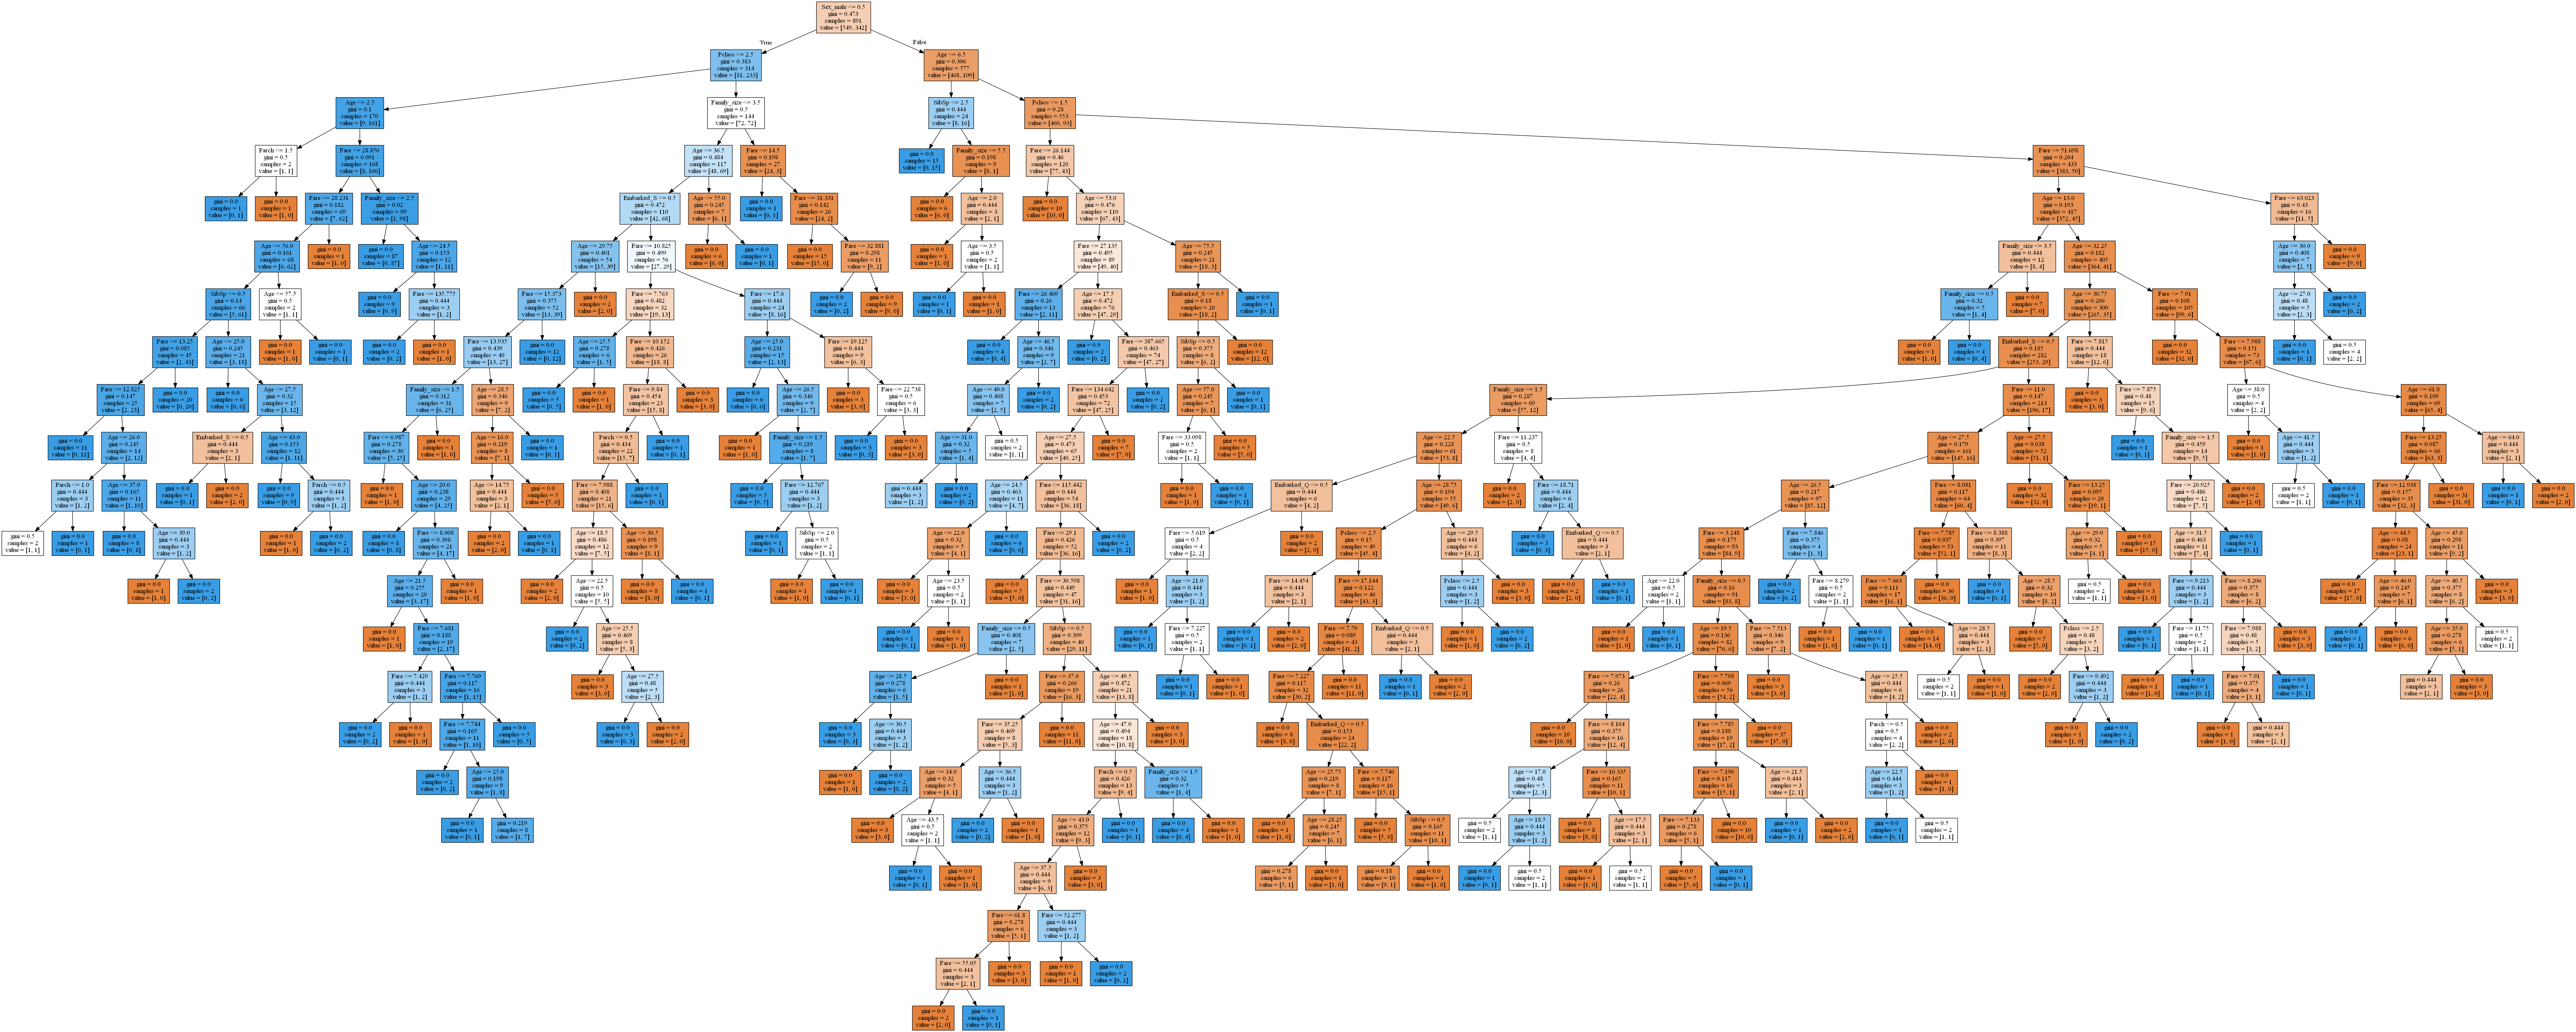

In [47]:
visualize_tree(dt_clf, X_train, 'tree');

#### 2) Подбор гиперпараметров с помощью GridSearchCV

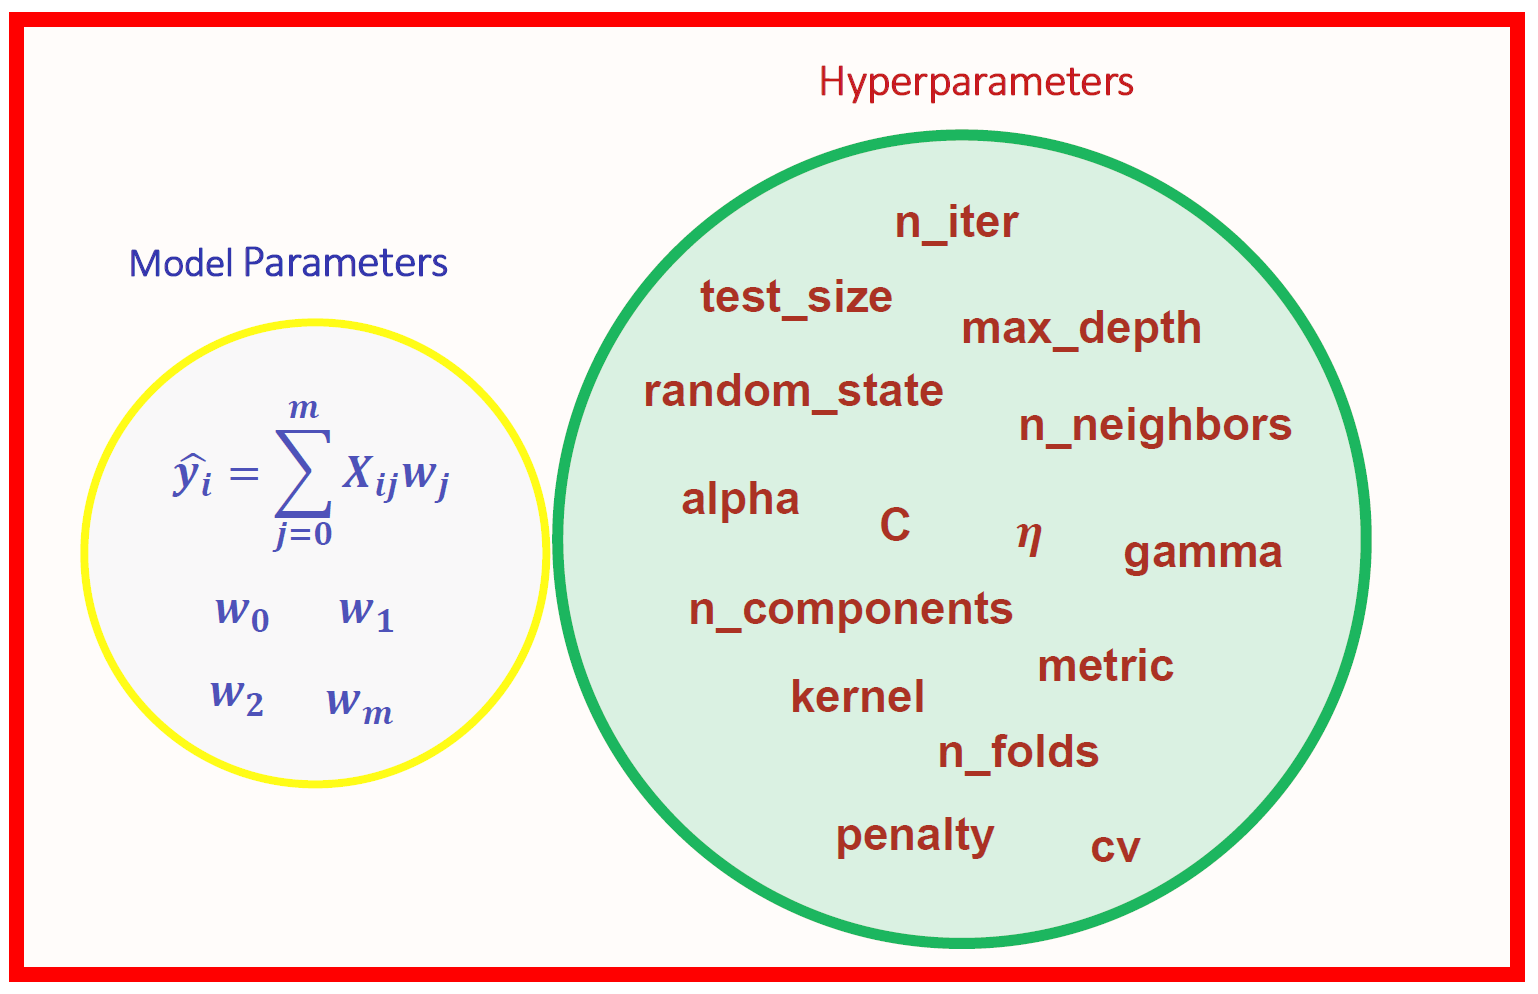

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
clf = DecisionTreeClassifier()

parameters = {
              'criterion': ['entropy', 'gini'],
              'max_depth': range(1, 10),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(1, 10)
             }


grid_cv = GridSearchCV(clf, parameters, cv=5)

In [50]:
%%time

grid_cv.fit(X_train, y_train)

Wall time: 23.1 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 10),
                         

In [51]:
best_model = grid_cv.best_estimator_

In [52]:
print('Лучшие параметры классификатора:', grid_cv.best_params_)

Лучшие параметры классификатора: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 3}


In [53]:
grid_pred = best_model.predict(X_test)

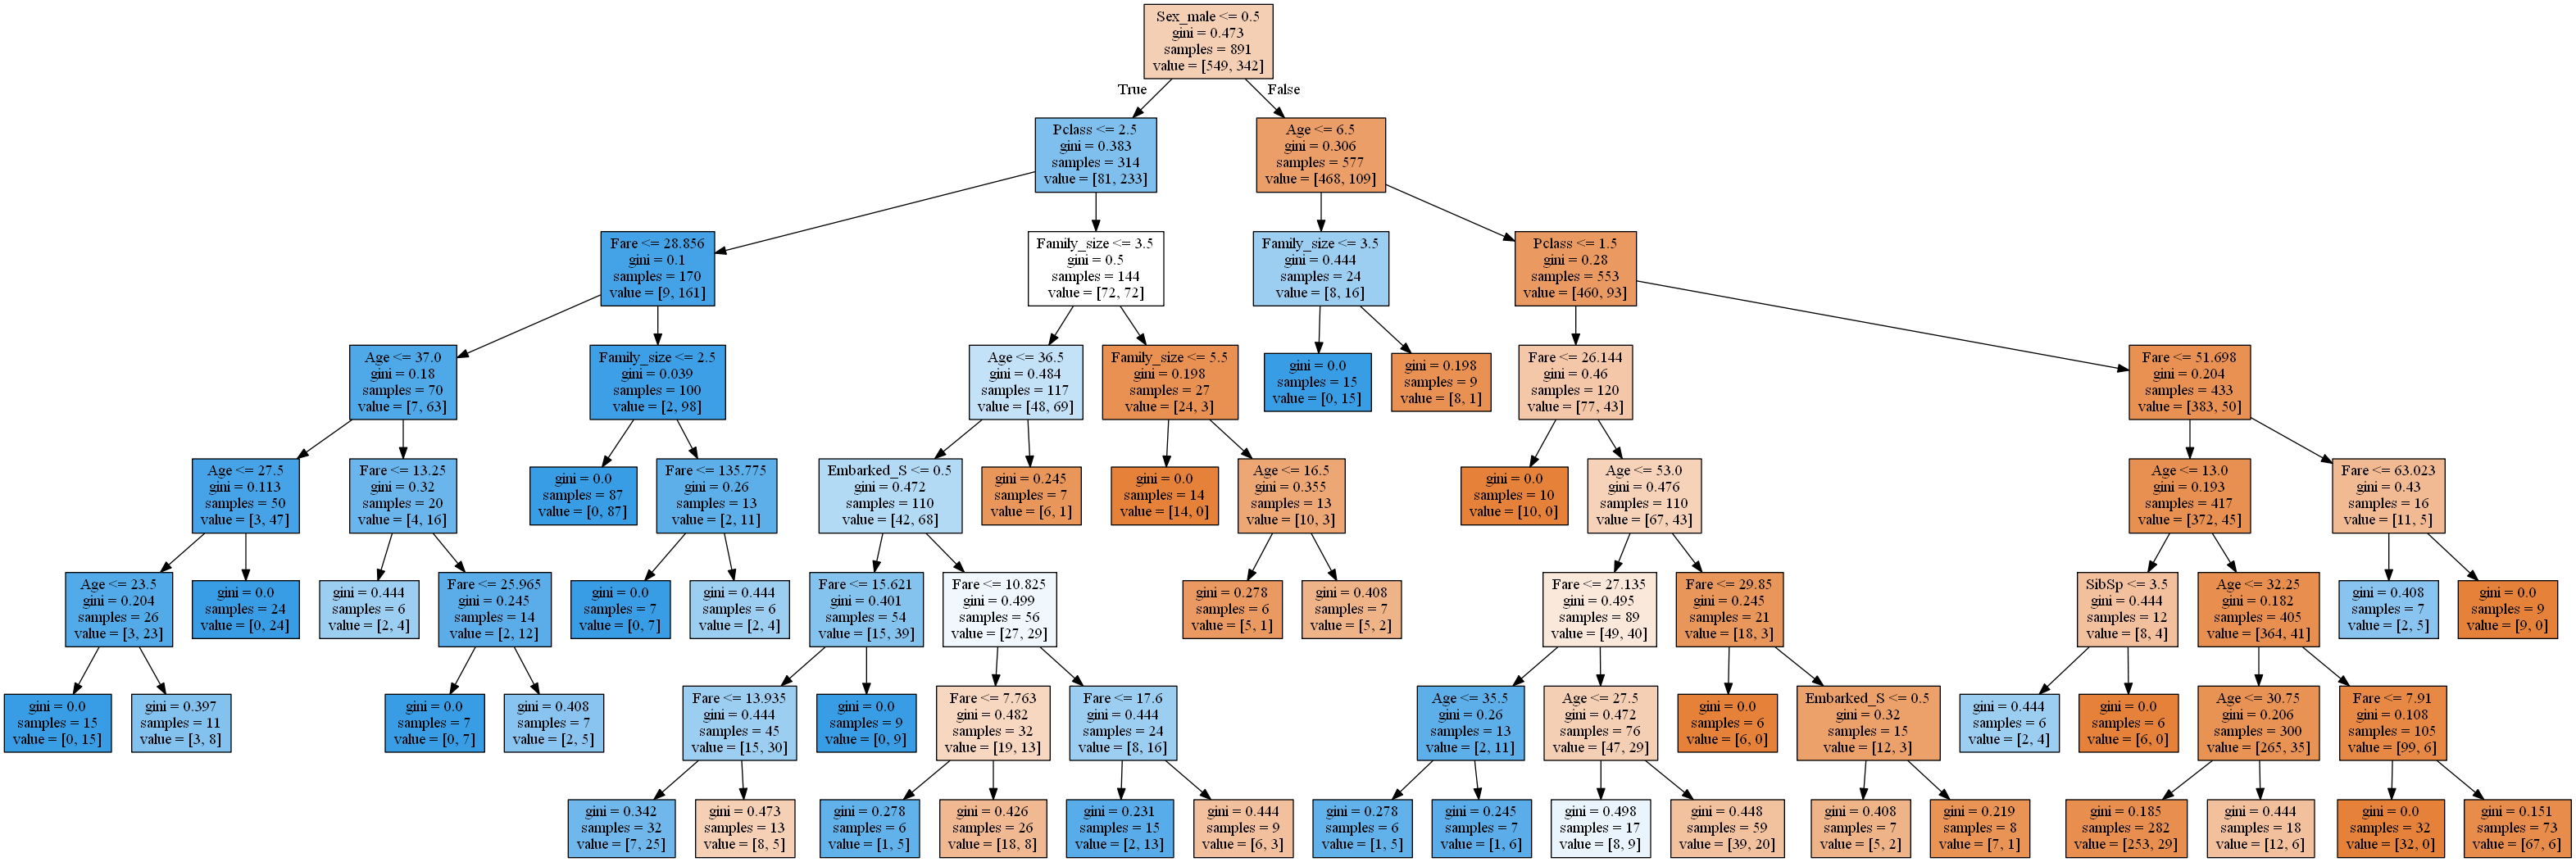

In [54]:
visualize_tree(best_model, X_train, 'tree_gridsearch')

#### 3) Более быстрый подбор гиперпараметров

In [55]:
from sklearn.model_selection import RandomizedSearchCV

In [56]:
random_grid_cv = RandomizedSearchCV(clf, parameters, cv=5)

In [57]:
%%time

random_grid_cv.fit(X_train, y_train);

Wall time: 186 ms


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [58]:
best_model_rand = random_grid_cv.best_estimator_

In [59]:
print('Лучшие параметры классификатора:', random_grid_cv.best_params_)

Лучшие параметры классификатора: {'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 7, 'criterion': 'gini'}


In [60]:
rand_grid_pred = best_model_rand.predict(X_test)

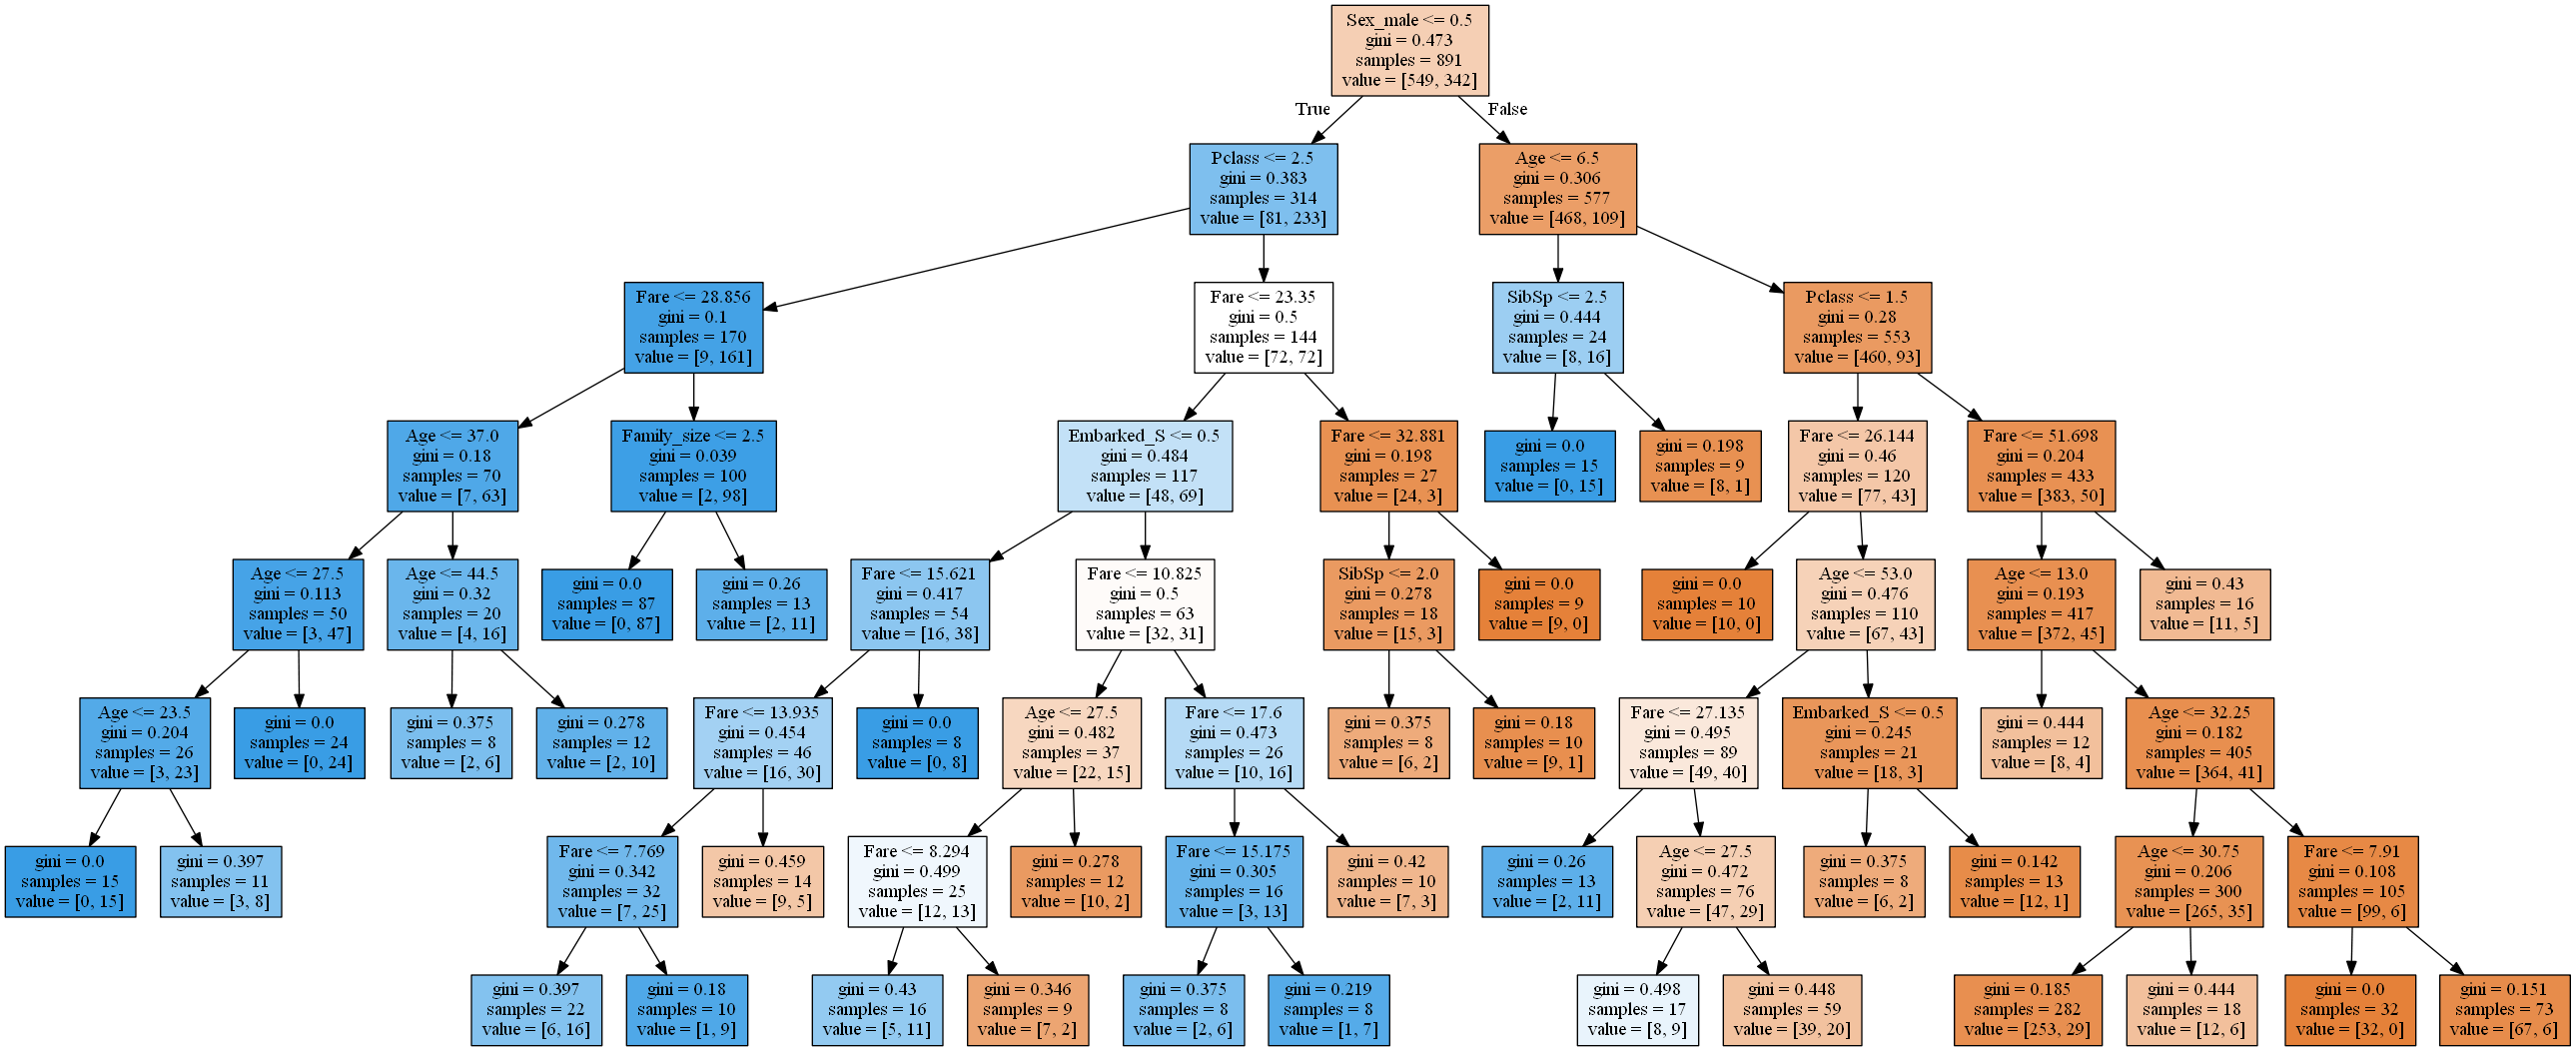

In [61]:
visualize_tree(best_model_rand, X_train, 'tree_rand')

### Результаты

#### 1) Простое решающее дерево

In [320]:
make_prediction_file(pred_dt_simple, test, 'titanic_dt_simple.csv')

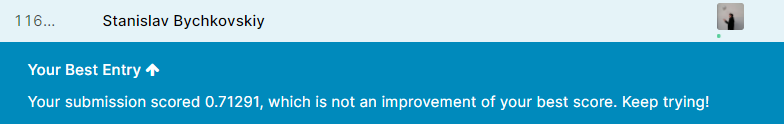

#### 2) Дерево, построенное с помощью GridSearchCV (лучший результат)

In [321]:
make_prediction_file(grid_pred, test, 'titanic_dt_gridcv.csv')

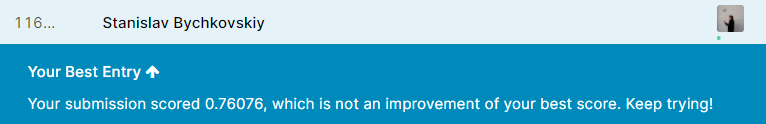

#### 3)  Дерево, построенное с помощью RandomizedSearchCV (лучше обычного, хуже лучшего)

In [322]:
make_prediction_file(rand_grid_pred, test, 'titanic_dt_rand_search.csv')

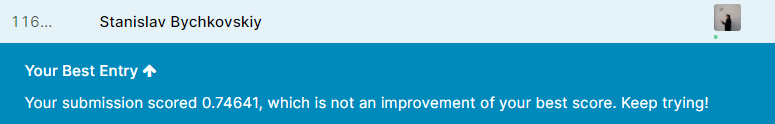

### Бонус: немного о переобучении

In [329]:
dt_best = DecisionTreeClassifier(max_depth=4)

dt_best.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

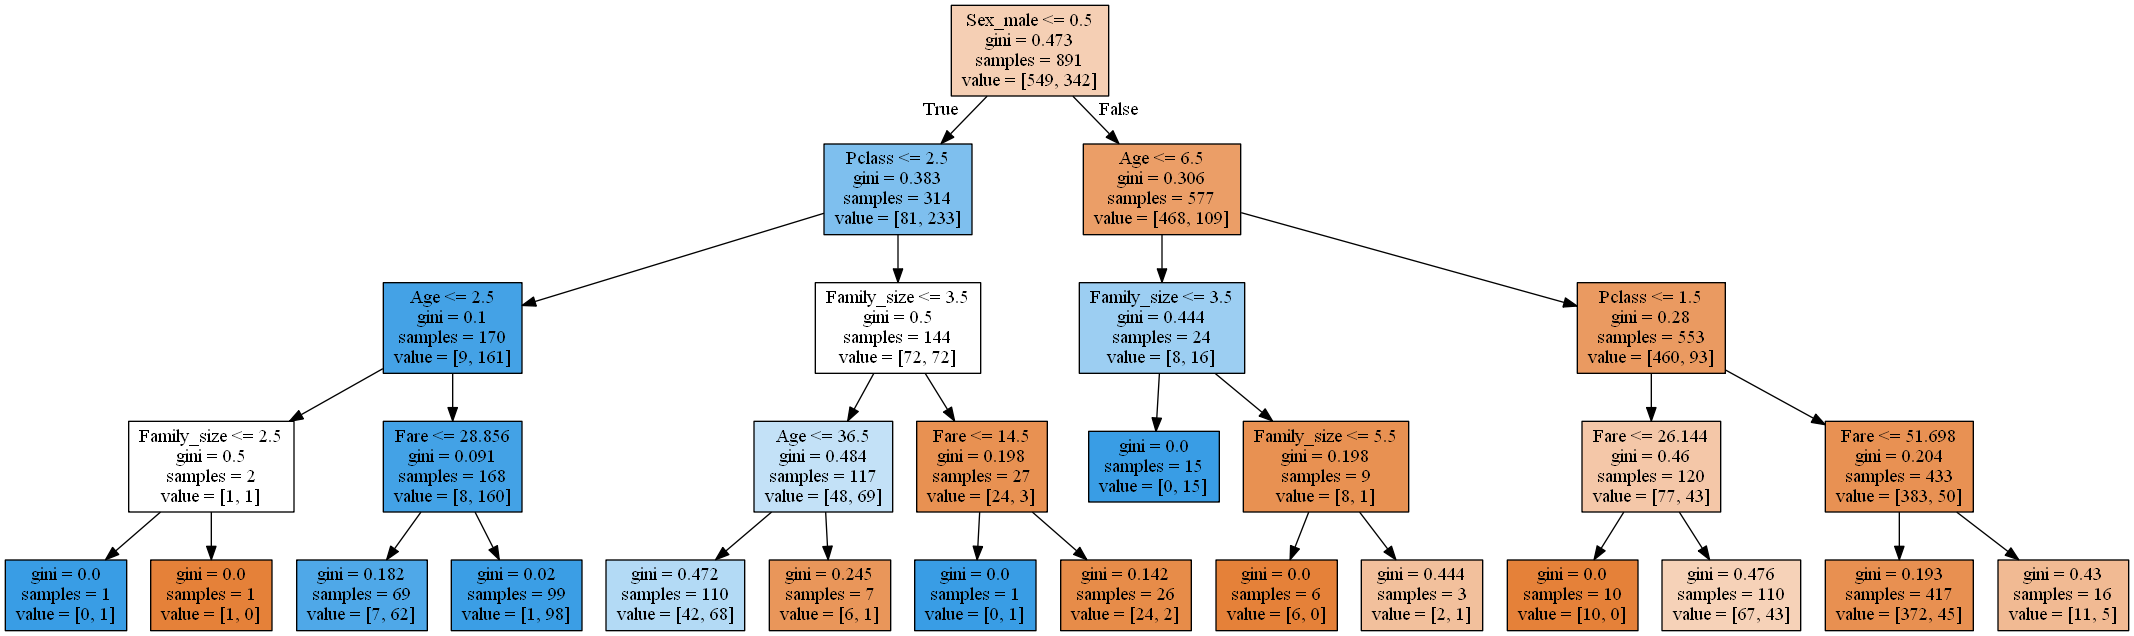

In [330]:
visualize_tree(dt_best, X_train, 'tree_best')

In [328]:
pred_tree_best = dt_best.predict(X_test)

make_prediction_file(pred_tree_best, test, 'titanic_dt_best.csv')

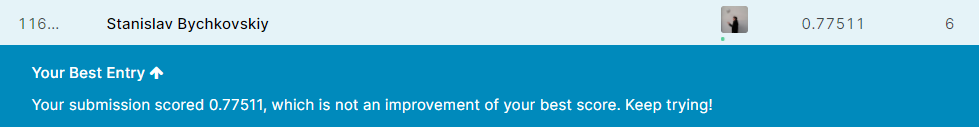

### Итог:

- Познакомились с настоящим алгоритмом машинного обучения - Decision Tree
- Научились обучать алгоритмы машинного обучения, делать предсказания с их помощью (fit -> predict)
- Узнали про различные способы подбора гиперпараметров
- Затронули тему переобучения

### Итог: Lifecycle ML-эксперимента

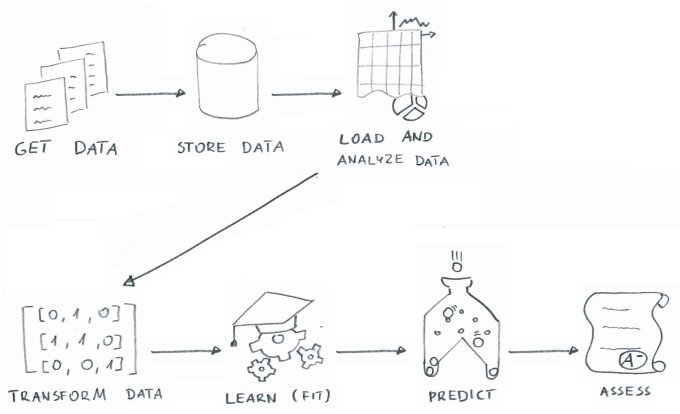

### Homework (optional)

- Попробуйте использовать линейную модель, например, логистическую регрессию. Изучите её, найдите её реализацию в sklearn, примените вместо решающего дерева, проверьте результат.


- Одно дерево хорошо, а лес - ещё лучше. Почитайте про ансамблевую модель машинного обучения - случайный лес - которая состоит из нескольких (десятков, сотен) решающих деревьев. Примените её здесь (есть готовая реализация в sklearn), подберите гиперпараметры (осторожно, может занять много времени!). Сравните результаты с предыдущими моделями.


- Поизучайте ноутбуки других участников этого соревнования - в них бывает много интересных идей!


- Экспериментируйте: с данными, с алгоритмами, с этим и любыми другими ноутбуками. Почувствуйте себя учёными :)

### Полезные ссылки

- https://www.kaggle.com/c/titanic - Titanic: Machine Learning from Disaster - дублирую ссылку на наше сегодняшнее соревнование, Kaggle. Для участия необходимо создать учётную запись.



- https://www.anaconda.com/products/individual - дублирую, на случай, если кто пропустил первую часть, - Anaconda3 - toolkit, в котором есть все необходимые инструменты для того, чтобы начать заниматься Data Science: Python последней версии, все использованные сегодня библиотеки (и куча других, ориентированных на ML/DS и научные вычисления), Jupyter Notebook и т.д. 



- https://habr.com/ru/company/ods/blog/322534/ - теория про DecisionTree, курс Open Data Science - крупнейшего русскоязычного Data Science-сообщества. Бесплатный.



- https://www.deeplearningbook.org/ - одна из лучших, если не лучшая, книга по машинному обучению. Сугубо теоретическая, первых пару глав покрывают всю необходимую математику. Бесплатная, в интернете можно нагуглить её вариант, собранный в один файл (авторы этого делать не стали и выложили так, как на сайте)


- https://www.coursera.org/specializations/machine-learning-data-analysis - довольно серьёзный и полезный набор из 6 курсов по машинному обучению от МФТИ и Яндекса. Есть краткое и несложное введение в нужную математику. Курсы можно прослушивать бесплатно, за сертификат нужно заплатить.

## <center> Спасибо за внимание!

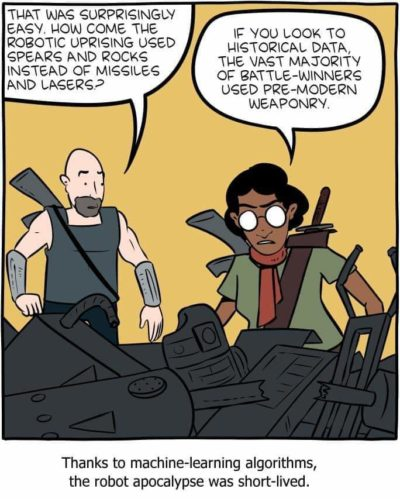